# Heat equation in 1D — Gaussian diffusion, periodic BC, RK4

**Goal.** Verify that the 1D heat equation
\[
u_t = \alpha\,u_{xx}
\]
with **periodic** boundary conditions conserves total mass \(M(t)=\int_0^L u(x,t)\,dx\) under a consistent finite‑difference scheme. We evolve a Gaussian bump using RK4 and plot:

- snapshots \(u(x,t)\) at a few times,
- the mass \(M(t)\) computed with Simpson’s rule (should be flat).

We also include a brief stability note for the chosen \(\Delta t\) vs \(\Delta x\).

## Imports & Config

In [1]:
import os, sys, importlib
import numpy as np

sys.path.append(os.path.abspath(".."))

from src.utils.config_loader import load_config
from src.numerics.laplacian_1d import make_laplacian_1d, make_laplacian_1d_dirichlet
from src.initial_conditions.profiles_1d import gaussian_bump, square_pulse  
from src.pdes.heat_solver_1d import run_heat_solver_1d
from src.core.time_integrators import rk4_step, euler_step
from src.utils.diagnostics import DiagnosticManager, plot_mass_evolution
from src.visualization.plotting_1d import plot_initial_final  

##  Load parameters & setup

In [2]:
# Load config from repo root
cfg = load_config("../config.yaml")

# Grid
L = float(cfg["grid"]["L"])
N = int(cfg["grid"]["N"])
dx = L / N
x = np.linspace(0, L, N, endpoint=False)

# Laplacian
if cfg["bc"]["type"].lower() == "periodic":
    L_op = make_laplacian_1d(N, dx)
elif cfg["bc"]["type"].lower() == "dirichlet":
    L_op = make_laplacian_1d_dirichlet(N, dx)
else:
    raise ValueError(f"Unknown BC type {cfg['bc']['type']}")

# Initial condition
ic = cfg["initial_condition"]
itype = str(ic.get("type", "gaussian")).lower()
center = float(ic.get("center", 0.35)) * L
sigma  = float(ic.get("sigma", 0.06)) * L
amp    = float(ic.get("amplitude", ic.get("amp", 1.0)))

if itype in ("gaussian", "gaussian_bump", "gauss"):
    u0 = gaussian_bump(x, center=center, sigma=sigma, amplitude=amp)
elif itype in ("square", "square_pulse", "top_hat"):
    u0 = square_pulse(x, center=center, width=sigma, amplitude=amp)
else:
    raise ValueError(f"Unknown initial_condition.type: {itype}")

##  Run solver + diagnostics + plots

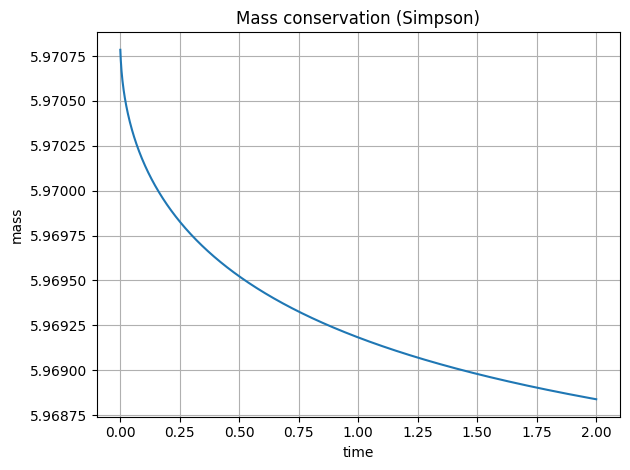

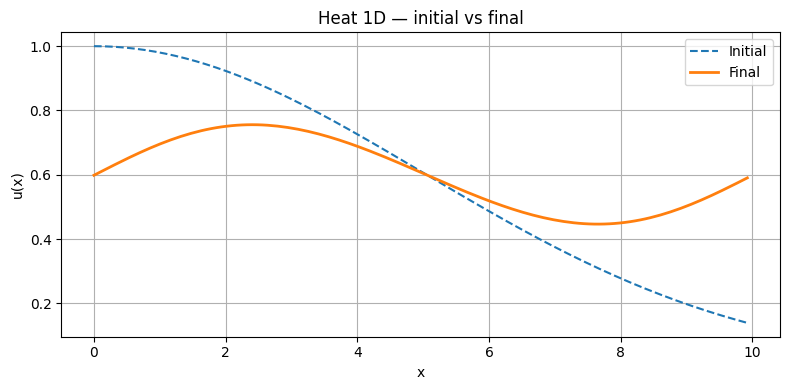

Saved diagnostics to figures


In [3]:
# Pick integrator
method = cfg["integrator"]["method"].lower()
step = {"rk4": rk4_step, "euler": euler_step}.get(method)
if step is None:
    raise ValueError(f"Unsupported integrator: {method}")

# Time params
dt = float(cfg["time"]["dt"])
T  = float(cfg["time"]["T"])

# Run solver
res = run_heat_solver_1d(
    L_op=L_op,
    u0=u0,
    T=T,
    dt=dt,
    dx=dx,               
    step_func=step       
)

# Unpack results (supports both return styles)
if isinstance(res, tuple) and len(res) == 2:
    u_hist, t_hist = res
else:
    u_hist = res
    t_hist = np.arange(len(u_hist)) * dt

# Diagnostics
dm = DiagnosticManager(dx=dx, track=("mass", "l2_norm"))
for u, t in zip(u_hist, t_hist):
    dm.track_step(u, t)

# Plots
plot_mass_evolution(u_hist, dx, times=t_hist, title="Mass conservation (Simpson)")
plot_initial_final(x, u0, u_hist[-1], title="Heat 1D — initial vs final")

# Save diagnostics
outdir = cfg["io"]["outdir"]; os.makedirs(outdir, exist_ok=True)
dm.save_csv(os.path.join(outdir, "heat1d_diagnostics.csv"))
dm.save_yaml(os.path.join(outdir, "heat1d_summary.yaml"))
print("Saved diagnostics to", outdir)

## Animation

In [4]:
import os
from src.visualization.animation_1d import save_animation_1d

outdir = cfg["io"]["outdir"]
os.makedirs(outdir, exist_ok=True)
mp4_path = os.path.join(outdir, "heat1d.mp4")

# dt from your config
dt = float(cfg["time"]["dt"])

ani, saved_path = save_animation_1d(
    x=x,
    u_history=u_hist,
    dt=dt,
    save_path=mp4_path,
    stride=1
)
print("Animation saved to:", saved_path)

Animation saved to: figures/heat1d.mp4


## Final summary

In [5]:
if dm.records:
    m0 = dm.records[0].get("mass")
    m1 = dm.records[-1].get("mass")
    drift = (m1 - m0) / (abs(m0) + 1e-15) if m0 is not None and m1 is not None else float("nan")
    print(f"Mass drift over run: {drift:.3e}")
print("Diagnostics CSV:", os.path.join(outdir, "heat1d_diagnostics.csv"))
print("Summary YAML:",   os.path.join(outdir, "heat1d_summary.yaml"))

Mass drift over run: -3.261e-04
Diagnostics CSV: figures/heat1d_diagnostics.csv
Summary YAML: figures/heat1d_summary.yaml
